# Generate plot for Single State


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-poster")
import matplotlib.gridspec as gridspec
from datetime import timedelta

def plot_results(df, int_vars:list, ax_arg=None, total=False,log=False, Reff=None,plotpath=False,legend=False,summary=False):
    if ax_arg is None:
        if Reff is None:
            fig, ax = plt.subplots(figsize=(12,9))
        else:
            #fig, (ax,ax2) = plt.subplots(figsize=(12,9),nrows=2,gridspec_kw={'height_ratios': [3, 1.5]}, sharex=True)
            fig = plt.figure(constrained_layout=True)
            gs = fig.add_gridspec(3, 1)
            ax = fig.add_subplot(gs[:2, 0])
            
            ax2 = fig.add_subplot(gs[2, 0],sharex=ax)
    else:

        ax2 = ax_arg[1]
        ax = ax_arg[0]
    if summary:
        #Using summary files
  
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns, df.loc[(var,'lower')], df.loc[(var,'upper')], alpha=0.4,color='C0')
            ax.fill_between(df.columns, df.loc[(var,'bottom')], df.loc[(var,'top')], alpha=0.4,color='C0')

            if plotpath:
                print("Cannot plot path using summary files")
                raise KeyError
            else:
                ax.plot(df.columns, df.loc[(var,'median')], label=var)

            ax.set_xticks([df.columns.values[-28]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #using the raw simulation files
        if total:
            for n in range(df.loc['symp_obs'].shape[0]):
                df.loc[('total_inci_obs',n),:] = df.loc[(int_vars[0],n)] + df.loc[(int_vars[1],n)]
            int_vars=['total_inci_obs']
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.05,axis=1), df.transpose()[var].quantile(0.95,axis=1), alpha=0.4,color='C0')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.25,axis=1), df.transpose()[var].quantile(0.75,axis=1), alpha=0.4,color='C0')

            if plotpath:
                ax.plot(df.columns, df.loc[(var,4)], label=var,alpha=0.6,color='C0')
                #ax.plot(df.columns, df.loc[(var,8)],alpha=0.6,color='C0')
                #ax.plot(df.columns, df.loc[(var,12)],alpha=0.8,color='C0')
            else:
                ax.plot(df.columns, df.transpose()[var].quantile(0.5,axis=1), label=var)

            ax.set_xticks([df.columns.values[-28]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')
    
    if len(int_vars)>1:
        ax.legend()
    ax.set_ylim(bottom=0)
    #ax.set_ylabel("Cases")
    if log:
        ax.set_yscale("log")
    if legend:
        fig.legend()
    
    if Reff is not None:
        
        ax2.plot(df.columns, Reff.loc[df.columns,range(1000)].mean(axis=1))
        ax2.fill_between(df.columns, Reff.loc[df.columns, 'bottom'],Reff.loc[df.columns, 'top'],alpha=0.4 ,color='C0')
        ax2.fill_between(df.columns, Reff.loc[df.columns, 'lower'],Reff.loc[df.columns, 'upper'],alpha=0.4,color='C0' )
        ax2.set_yticks([1],minor=True,)
        ax2.set_yticks([0,2],minor=False)
        ax2.set_yticklabels([0,2],minor=False)
        ax2.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
        #ax2.set_ylabel("Reff")
        ax2.tick_params('x',rotation=45)
        plt.setp(ax.get_xticklabels(), visible=False)
        #ax2.set_xlabel("Date")
        
        ax2.set_xticks([df.columns.values[-28]],minor=True)
        ax2.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #ax.set_xlabel("Date")
        ax.tick_params('x',rotation=45)
    if ax_arg is None:
        if Reff is None:
            return fig,ax
        else:
            return fig,ax,ax2
    else:
        return ax,ax2

def read_in_Reff(forecast_R=None,R_I=None):
        """
        Read in Reff csv from Price et al 2020. Originals are in RDS, are converted to csv in R script
        """
        import pandas as pd
        import os
        
        dir_path = os.path.dirname(os.getcwd())
        
        datapath = os.path.join(dir_path,'data/')
        #df= pd.read_csv(datapath+'R_eff_2020_04_23.csv', parse_dates=['date'])
        #df = df.loc[df.date>= self.start_date]
        
        #df = df.set_index(['state','date'])
        
        
        if forecast_R is not None:
            df_forecast = pd.read_hdf(datapath+'soc_mob_R2020-08-03.h5',
            key='Reff')
            
            if R_I is not None:
                mean = df_forecast.loc[df_forecast.type=='R_I','mean'].values[0]
                std = df_forecast.loc[df_forecast.type=='R_I','std'].values[0]
                R_I = np.random.gamma(mean**2/std**2, std**2/mean, size=100)

            #R_L here 
   

            df_forecast = df_forecast.loc[df_forecast.type==forecast_R]
            df_forecast.set_index(['state','date'],inplace=True)
            df = df_forecast
            #df = pd.concat([
            #            df.drop(['type','date_onset','confidence',
            #                 'mean_window','prob_control',
            #                'sd_window'],axis=1),
            #            df_forecast.drop(['type'],axis=1)
            #                ])
            #df = df.reset_index().drop_duplicates(['state','date'],keep='last')
            #df = df.set_index(['state','date'])
        
        
        return df
    
def read_in_cases(cases_file_date=None):
    """
    Read in NNDSS case file data
        
    """
    import pandas as pd
    from datetime import timedelta
    import glob

    if cases_file_date is None:
        import glob, os

        list_of_files = glob.glob("../data/"+'COVID-19 UoM*.xlsx') 
        path = max(list_of_files, key=os.path.getctime)
        print("Using file "+path)
    else:
        path = "../data/"+"COVID-19 UoM "+cases_file_date+"*.xlsx"

    for file in glob.glob(path):
        df = pd.read_excel(file,
                   parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                   dtype= {'PLACE_OF_ACQUISITION':str})
    if len(glob.glob(path))!=1:
        print("There are %i files with the same date" %len(glob.glob(path)))

        if len(glob.glob(path)) >1:
            print("Using an arbritary file")
    
    df.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

    df['date_inferred'] = df.TRUE_ONSET_DATE
    #missing_cases = df.groupby('STATE').TRUE_ONSET_DATE.agg(lambda x: sum(x.isna()))
    #print("Unknown Symptom onset dates")
    #display(missing_cases)
    df.loc[df.TRUE_ONSET_DATE.isna(),'date_inferred'] = df.loc[df.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
    df.loc[df.date_inferred.isna(),'date_inferred'] = df.loc[df.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)

    df['imported'] = df.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
    df['local'] = 1 - df.imported
    
    
    df_cases_state_time = df.groupby(['STATE','date_inferred'])[['imported','local']].sum()
    df_cases_state_time.reset_index(inplace=True)
    
    df_cases_state_time['cum_imported'] = df_cases_state_time.groupby('STATE').imported.transform(pd.Series.cumsum)
    df_cases_state_time['cum_local'] = df_cases_state_time.groupby('STATE').local.transform(pd.Series.cumsum)

    return df_cases_state_time

## Plot from quantile summary

forecast up to: 2020-08-31 00:00:00


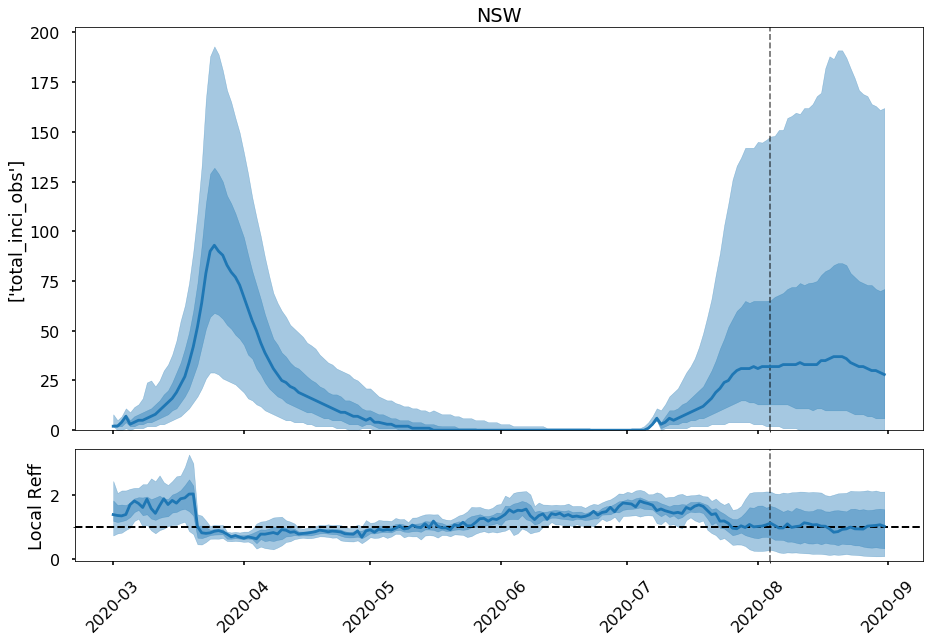

In [25]:
state = 'NSW'
n_sims = 6000
start_date = '2020-03-01'
days = 184
forecast_type = 'R_L' #default is 'R_L'
plot_nndss_cases=False

#Read in reproduction number used
Reff = read_in_Reff( forecast_R=forecast_type)

end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days-1)

print("forecast up to: {}".format(end_date))

#read in the results file
df_results = pd.read_parquet("../results/quantiles"+forecast_type+start_date+"sim_"+str(
    n_sims)+"days_"+str(days)+".parquet")


#manipulate the results file into the right format
df_results = pd.melt(df_results, id_vars=['state','date','type'],
                     value_vars=['bottom','lower','median','upper','top'],
                    )

df_results = pd.pivot_table(df_results, 
                            index=['state','type','variable'],
                            columns='date',
                            values='value')

#CHANGE THE FOLLOWING ARGUMENTS FOR PLOTTING DIFFERENT GROUPS
## for local detected cases = ['total_inci_obs'],  
## for local observed symptomatic cases use ['symp_inci_obs']
## for all local symptomatic cases use ['symp_inci'], this will be indexed by infection date

group_to_plot = ['total_inci_obs']

fig,ax,ax2= plot_results(df_results.loc[state], group_to_plot,summary=True, Reff=Reff.loc[state])

if plot_nndss_cases:
    df_cases_state_time = read_in_cases()
    dfplot = df_cases_state_time.loc[
        (df_cases_state_time.STATE==state) 
        & (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    
    ax.bar(dfplot.date_inferred,dfplot.local, label='Actual',color='grey', alpha=0.6)

ax.set_ylabel(group_to_plot)
ax2.set_ylabel("Local Reff")

ax.set_title(state)
plt.show()

#plt.savefig("../figs/"+forecast_type+start_date+"local_inci_"+str(n_sims)+"days_"+str(days)+'.pdf')

## Plot from raw file

In [ ]:

date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(start_date,end_date)]
    
df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",columns=date_col)
    

#CHANGE THE FOLLOWING ARGUMENTS FOR PLOTTING DIFFERENT GROUPS
## for local detected cases = ['total_inci_obs'],  
## for local observed symptomatic cases use ['symp_inci_obs']
## for all local symptomatic cases use ['symp_inci'], this will be indexed by infection date

## Set plotpath to True if you want to see some actual simualtion paths rather than just qauntiles
group_to_plot = ['total_inci_obs']
fig, ax= plot_results(df_results,group_to_plot,plotpath=True,log=False) 

if plot_nndss_cases:
    df_cases_state_time = read_in_cases()
    dfplot = df_cases_state_time.loc[
         (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    dfplot = dfplot.loc[dfplot.STATE==state].set_index('date_inferred')
    ax.bar(dfplot.index,dfplot.local, label='Actual',color='grey',alpha=0.6 )

ax.set_title(state)
ax.set_ylabel(group_to_plot)
plt.show()    
    